# ANN模型

In [29]:
import numpy as np
from keras import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras import regularizers
from sklearn import metrics

In [160]:
#加载数据
# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 200) (2948, 200) (2948, 200)
Y: (8844,) (2948,) (2948,)


# 1. ANN
# 使用keras 的Sequential API

INFO:tensorflow:Assets written to: ../saved_model/ann_model/assets


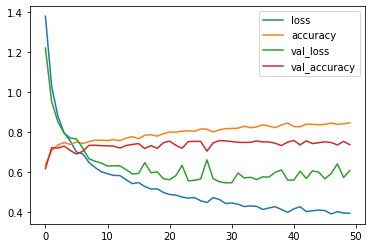

93/93 [==============================] - 0s 1ms/step - loss: 0.6066 - accuracy: 0.7364


([0.39615678787231445, 0.8418136835098267],
 [0.6066239476203918, 0.7364314794540405])

In [27]:
#创建模型
model = Sequential()
input_shape = (200,)
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.L2(0.005),input_shape=input_shape))
model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.L2(0.002)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  

#训练模型
hist = model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_dev,y_dev),verbose=0)

#保存模型
model.save("../saved_model/ann_model")

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

model.evaluate(X_train,y_train),model.evaluate(X_dev,y_dev)
#问题，在NN模型下，测试集1数据太小

{'accuracy': 0.736,
 'precision': 0.703,
 'recall': 0.825,
 'f1': 0.759,
 'auc': 0.825}

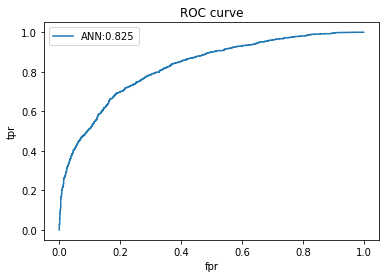

In [30]:
pred_prob = model.predict(X_test)
#该函数用于评价结果与绘图
def assess(y_true,y_prob,roc=True,pr=False,poly_name=None,line_name=None):
    '''
    pass
    '''
    re={}
    y_pred =(y_prob+0.5).astype(int)
    
    re['accuracy'] = round(metrics.accuracy_score  (y_true,y_pred),3)
    re['precision'] = round(metrics.precision_score(y_true,y_pred),3)
    re['recall'] = round(metrics.recall_score      (y_true,y_pred),3)
    re['f1'] =  round(metrics.f1_score             (y_true,y_pred),3)
    re['auc'] = round(metrics.roc_auc_score        (y_true, y_prob),3)
    
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_prob)
    plt.plot(fpr,tpr,label= 'ANN:'+str(re['auc']))
    plt.title('ROC curve')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    
    #precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_prob)
    #plt.plot(precision,recall,label='precison_and_recall')
    plt.legend()
    
    return re

assess(y_test,pred_prob)


In [32]:
#保存测试结果
np.save("../save_pred/ann_pred_y_test",y_test)
np.save("../save_pred/ann_pred_proba",pred_prob)

# 2. ANN
# 使用keras Sequential API
因为ANN不能有效提取polyA序列的顺序信息，这里使用k-mer方式重新编码数据，看看能不能提升ANN的性能  <br />
通过k-mer处理可以得到两种方式的数据，<br />
(1)一种是统计k-mer的频数 <br />
(2)一种是将k-mer转化成数字的序列 

# (1)首先使用第一方式

In [152]:
def init_kmers_list(k):
    base  = ['1','2','3','4']
    kmers = ['1','2','3','4']
    def str_mult(base1, base2):
        return [j+i for j in base2 for i in base1]
    
    for i in range(k-1):
        kmers = str_mult(base,kmers)
    
    return kmers

def init_kmers_dict_count(k=2):
    kmers_list = init_kmers_list(k)
    kmers_dict_count={}
    for kmer in kmers_list:
        kmers_dict_count[kmer] = 0 
    return kmers_dict_count

def init_kmers_dict_num(k=2):
    kmers_list = init_kmers_list(k)
    kmers_dict={}
    for idx,kmer in enumerate(kmers_list):
        kmers_dict_num[kmer] = idx+1 
    return kmers_dict_num        

In [161]:
#使用2kmer
#第二遍运行报错，只需要运行一次，原始数据已经被修改
kmers_dict_count = init_kmers_dict_count(2)
def convert_to_kmers_count(x,k=2):
    count = kmers_dict_count.copy()
    seq = ""
    for i in x:        
        seq += str(i)

    for i in range(len(x)-k+1):
        count[seq[i:i+k]] += 1
    return np.array([value for key,value in count.items()])/16


# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据
X_train = np.vstack([convert_to_kmers_count(a) for a in X_train])
X_dev = np.vstack([convert_to_kmers_count(a) for a in X_dev])
X_test = np.vstack([convert_to_kmers_count(a) for a in X_test])

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 16) (2948, 16) (2948, 16)
Y: (8844,) (2948,) (2948,)


INFO:tensorflow:Assets written to: ../saved_model/ann_model/assets


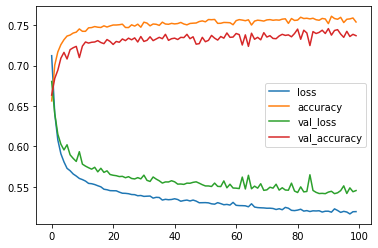

93/93 [==============================] - 0s 1ms/step - loss: 0.5453 - accuracy: 0.7371


([0.5188060998916626, 0.7597240805625916],
 [0.5453302264213562, 0.737109899520874])

In [163]:
#创建模型
model = Sequential()
input_shape = (16,)
model.add(Dense(16,activation='relu',kernel_regularizer=regularizers.L2(0.005),input_shape=input_shape))
model.add(Dense(16,activation='relu',kernel_regularizer=regularizers.L2(0.002)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  

#训练模型
hist = model.fit(X_train,y_train,epochs=100,batch_size=64,validation_data=(X_dev,y_dev),verbose=0)

#保存模型
model.save("../saved_model/ann_model")

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

model.evaluate(X_train,y_train),model.evaluate(X_dev,y_dev)

# 提示
2 kmer的处理方式，模型性能并没有提升 <br />
接下来改成 3 kmer

In [164]:
#使用2kmer
#第二遍运行报错，只需要运行一次，原始数据已经被修改
kmers_dict_count = init_kmers_dict_count(3)
def convert_to_kmers_count(x,k=3):
    count = kmers_dict_count.copy()
    seq = ""
    for i in x:        
        seq += str(i)

    for i in range(len(x)-k+1):
        count[seq[i:i+k]] += 1
    return np.array([value for key,value in count.items()])/16


# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据
X_train = np.vstack([convert_to_kmers_count(a) for a in X_train])
X_dev = np.vstack([convert_to_kmers_count(a) for a in X_dev])
X_test = np.vstack([convert_to_kmers_count(a) for a in X_test])

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 64) (2948, 64) (2948, 64)
Y: (8844,) (2948,) (2948,)


INFO:tensorflow:Assets written to: ../saved_model/ann_model/assets


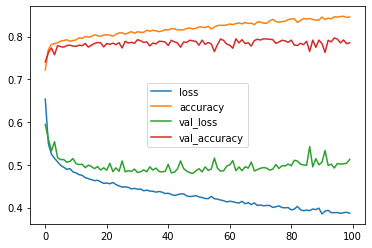

93/93 [==============================] - 0s 1ms/step - loss: 0.5127 - accuracy: 0.7856


([0.38165903091430664, 0.8481456637382507],
 [0.5127459764480591, 0.7856173515319824])

In [171]:
#创建模型
model = Sequential()
input_shape = (64,)
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.L2(0.001),input_shape=input_shape))
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.L2(0.001)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  

#训练模型
hist = model.fit(X_train,y_train,epochs=100,batch_size=64,validation_data=(X_dev,y_dev),verbose=0)

#保存模型
model.save("../saved_model/ann_model")

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

model.evaluate(X_train,y_train),model.evaluate(X_dev,y_dev)


Instructions for updating:
Please use `model.predict()` instead.


{'accuracy': 0.785,
 'precision': 0.761,
 'recall': 0.838,
 'f1': 0.797,
 'auc': 0.868}

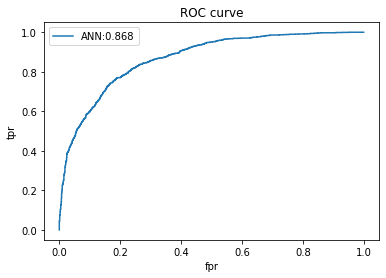

In [172]:
pred_prob = model.predict_proba(X_test)
assess(y_test,pred_prob)
#保存测试结果
np.save("../save_pred/ann_kmer_pred_proba.npy",pred_prob)

模型性能得到明显提升 <br />
将这个结果作为kmer的第一方式 ，ANN训练的最终结果进行保存

# (2 )第二种方式

首先测试2 kmer的情况 <br />
然后测试3 kmer的情况

In [177]:
def init_kmers_list(k):
    base  = ['1','2','3','4']
    kmers = ['1','2','3','4']
    def str_mult(base1, base2):
        return [j+i for j in base2 for i in base1]
    
    for i in range(k-1):
        kmers = str_mult(base,kmers)
    
    return kmers

def init_kmers_dict_count(k=2):
    kmers_list       = init_kmers_list(k)
    kmers_dict_count = {}
    for kmer in kmers_list:
        kmers_dict_count[kmer] = 0 
    return kmers_dict_count

def init_kmers_dict_num(k=2):
    kmers_list     = init_kmers_list(k)
    kmers_dict_num = {}
    for idx,kmer in enumerate(kmers_list):
        kmers_dict_num[kmer] = idx+1 
    return kmers_dict_num        

In [214]:
#使用2kmer
kmers_dict_num = init_kmers_dict_num(2)
def convert_to_kmers_num(x,k=2):
    seq = ""
    for i in x:        
        seq += str(i)
    return np.array([kmers_dict_num[seq[i:i+k]] for i in range(len(x)-k+1)])/16



In [215]:
# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据
X_train = np.vstack([convert_to_kmers_num(a) for a in X_train])
X_dev = np.vstack([convert_to_kmers_num(a) for a in X_dev])
X_test = np.vstack([convert_to_kmers_num(a) for a in X_test])

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 199) (2948, 199) (2948, 199)
Y: (8844,) (2948,) (2948,)


INFO:tensorflow:Assets written to: ../saved_model/ann_model/assets


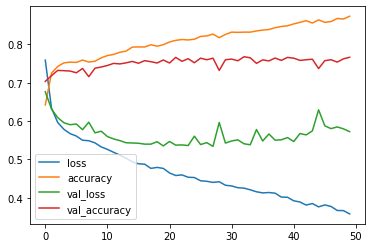

93/93 [==============================] - 0s 1ms/step - loss: 0.5725 - accuracy: 0.7663


([0.3445298671722412, 0.882632315158844],
 [0.572515070438385, 0.7662822008132935])

In [219]:
#创建模型
model = Sequential()
input_shape = (199,)
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.L2(0.002),input_shape=input_shape))
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.L2(0.002)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  

#训练模型
hist = model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_dev,y_dev),verbose=0)

#保存模型
model.save("../saved_model/ann_model")

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

model.evaluate(X_train,y_train),model.evaluate(X_dev,y_dev)


从这里可以看出，第二中方式的性能比第一种方式弱<br />
接下来测试3 kmer的情况

In [226]:
#使用2kmer
kmers_dict_num = init_kmers_dict_num(3)
def convert_to_kmers_num(x,k=3):
    seq = ""
    for i in x:        
        seq += str(i)
    return np.array([kmers_dict_num[seq[i:i+k]] for i in range(len(x)-k+1)])/64



In [227]:
# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据
X_train = np.vstack([convert_to_kmers_num(a) for a in X_train])
X_dev = np.vstack([convert_to_kmers_num(a) for a in X_dev])
X_test = np.vstack([convert_to_kmers_num(a) for a in X_test])

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 198) (2948, 198) (2948, 198)
Y: (8844,) (2948,) (2948,)


INFO:tensorflow:Assets written to: ../saved_model/ann_model/assets


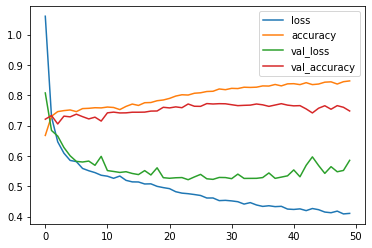

93/93 [==============================] - 0s 1ms/step - loss: 0.5856 - accuracy: 0.7483


([0.4284038245677948, 0.8309588432312012],
 [0.5856243968009949, 0.7483039498329163])

In [230]:
#创建模型
model = Sequential()
input_shape = (198,)
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.L2(0.005),input_shape=input_shape))
model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.L2(0.005)))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])  

#训练模型
hist = model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_dev,y_dev),verbose=0)

#保存模型
model.save("../saved_model/ann_model")

import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

model.evaluate(X_train,y_train),model.evaluate(X_dev,y_dev)


第二种方式的效果确实不好